In [1]:
import getpass
import pyspark
from pyspark.sql import SparkSession

conf = pyspark.conf.SparkConf()
# conf.setMaster('yarn')
conf.setMaster('local[2]')
conf.setAppName('twitter-{0}'.format(getpass.getuser()))
conf.set('spark.executor.memory', '4g')
conf.set('spark.executor.instances', '6')
conf.set('spark.port.maxRetries', '100')
sc = pyspark.SparkContext.getOrCreate(conf)
conf = sc.getConf()
sc

exec:  None
args:  ['/home/marco/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/pyspark/./bin/spark-submit', '--conf', 'spark.master=local[2]', '--conf', 'spark.app.name=twitter-marco', '--conf', 'spark.executor.memory=4g', '--conf', 'spark.executor.instances=6', '--conf', 'spark.port.maxRetries=100', 'pyspark-shell']


<SparkContext master=local[2] appName=twitter-marco>

In [2]:
spark = SparkSession(sc)

In [4]:
limited_df = spark.read.option("delimiter", ";").option("header", "true").csv('/home/marco/Downloads/2017-09')

In [7]:
from pyspark.sql import functions as F
from pandas import Series

formatTS1 = "dd.MM.yyyy HH:mm:ss"
formatTS2 = "dd.MM.yyyy HH:mm"
# df2 = df1.withColumn('Timestamp2', F.unix_timestamp('Timestamp', format).cast('timestamp'))

departure_delay = (F.unix_timestamp('AB_PROGNOSE', formatTS1) - 
        F.unix_timestamp('ABFAHRTSZEIT', formatTS2))
arrival_delay = (F.unix_timestamp('AN_PROGNOSE', formatTS1) - 
        F.unix_timestamp('ANKUNFTSZEIT', formatTS2))

day_week = F.to_date('BETRIEBSTAG', 'dd.MM.yyyy')

limited_df_filtered = (limited_df.filter((limited_df.AN_PROGNOSE_STATUS == 'GESCHAETZT') & (limited_df.AB_PROGNOSE_STATUS == 'GESCHAETZT'))
     .withColumn("arrival_delay", arrival_delay)
     .withColumn("departure_delay", departure_delay)
     .withColumn("day_week", F.dayofweek(day_week)))

# limited_df_filtered.groupBy(['FAHRT_BEZEICHNER']).count().take(100)
(limited_df_filtered.rdd
                       .groupBy(lambda x: (x.FAHRT_BEZEICHNER, x.day_week ))
                       .map(lambda triplet: (triplet[0], list(Series(list(triplet[1]))
                                             .map(lambda stop: (stop.HALTESTELLEN_NAME, stop.ANKUNFTSZEIT, stop.AN_PROGNOSE, stop.ABFAHRTSZEIT, stop.AB_PROGNOSE)))))
                       .take(100) )


[(('80:07____:3040:000', 4),
  [('Schaffhausen',
    '27.09.2017 08:14',
    '27.09.2017 08:33:55',
    '27.09.2017 08:16',
    '27.09.2017 08:34:55'),
   ('Schaffhausen',
    '13.09.2017 08:14',
    '13.09.2017 08:14:38',
    '13.09.2017 08:16',
    '13.09.2017 08:16:42'),
   ('Schaffhausen',
    '20.09.2017 08:14',
    '20.09.2017 08:14:23',
    '20.09.2017 08:16',
    '20.09.2017 08:16:33')]),
 (('80:07____:3069:000', 4),
  [('Schaffhausen',
    '27.09.2017 16:42',
    '27.09.2017 16:44:49',
    '27.09.2017 16:43',
    '27.09.2017 16:46:10'),
   ('Schaffhausen',
    '13.09.2017 16:42',
    '13.09.2017 16:42:51',
    '13.09.2017 16:43',
    '13.09.2017 16:44:21'),
   ('Schaffhausen',
    '20.09.2017 16:42',
    '20.09.2017 16:46:28',
    '20.09.2017 16:43',
    '20.09.2017 16:47:59')]),
 (('80:07____:3073:000', 4),
  [('Schaffhausen',
    '27.09.2017 20:42',
    '27.09.2017 20:43:20',
    '27.09.2017 20:43',
    '27.09.2017 20:44:21'),
   ('Schaffhausen',
    '13.09.2017 20:42',
    

In [11]:
from pyspark.sql import functions as F
from pandas import Series

# trip_ip: FAHRT_BEZEICHNER
# delay = AN_PROGNOSE - ANKUNFTSZEIT
# HALTESTELLEN_NAME: name of the stop

collected_df = (limited_df_filtered.select('FAHRT_BEZEICHNER', 'LINIEN_ID', 'HALTESTELLEN_NAME', 'day_week', 'ANKUNFTSZEIT', 'arrival_delay', 'ABFAHRTSZEIT', 'departure_delay')
        .collect())
 #.take(10))

In [91]:
df_with_delays = limited_df_filtered.select('FAHRT_BEZEICHNER', 'LINIEN_ID', 'HALTESTELLEN_NAME', 'day_week', 'ANKUNFTSZEIT', 'arrival_delay', 'ABFAHRTSZEIT', 'departure_delay')
df_with_delays = df_with_delays.filter((df_with_delays['arrival_delay'] > -1000) &
                                       (df_with_delays['arrival_delay'] < 1000) &
                                       (df_with_delays['departure_delay'] > -1000) &
                                       (df_with_delays['departure_delay'] < 1000)
                                      )
# arrival_delays = df_with_delays.select('arrival_delay').toPandas()
# departure_delays = df_with_delays.select('departure_delay').toPandas()

# for x in arrival_delays.take(10):
#     print(x[0])

df_with_delays.take(10)

[Row(FAHRT_BEZEICHNER='80:07____:3041:000', LINIEN_ID='3041', HALTESTELLEN_NAME='Schaffhausen', day_week=4, ANKUNFTSZEIT='27.09.2017 07:42', arrival_delay=94, ABFAHRTSZEIT='27.09.2017 07:43', departure_delay=108),
 Row(FAHRT_BEZEICHNER='80:07____:3042:000', LINIEN_ID='3042', HALTESTELLEN_NAME='Schaffhausen', day_week=4, ANKUNFTSZEIT='27.09.2017 10:14', arrival_delay=97, ABFAHRTSZEIT='27.09.2017 10:16', departure_delay=93),
 Row(FAHRT_BEZEICHNER='80:07____:3043:000', LINIEN_ID='3043', HALTESTELLEN_NAME='Schaffhausen', day_week=4, ANKUNFTSZEIT='27.09.2017 09:42', arrival_delay=97, ABFAHRTSZEIT='27.09.2017 09:43', departure_delay=108),
 Row(FAHRT_BEZEICHNER='80:07____:3044:000', LINIEN_ID='3044', HALTESTELLEN_NAME='Schaffhausen', day_week=4, ANKUNFTSZEIT='27.09.2017 12:14', arrival_delay=155, ABFAHRTSZEIT='27.09.2017 12:16', departure_delay=114),
 Row(FAHRT_BEZEICHNER='80:07____:3045:000', LINIEN_ID='3045', HALTESTELLEN_NAME='Schaffhausen', day_week=4, ANKUNFTSZEIT='27.09.2017 11:42', arr

In [ ]:
from matplotlib.pyplot import hist

# arrival_delays[arrival_delays['arrival_delay'] < -1000] = 0
# arrival_delays[arrival_delays['arrival_delay'] > 1000] = 0

# n, bins, patches = hist(arrival_delays.arrival_delay, bins=100)
n, bins, patches = hist(df_with_delays.select('arrival_delay').collect(), bins=100)
# arrival_delays.groupby(['arrival_delay']).count()
# df_with_delays.groupby('arrival_delay').count().take(10)

# arrival_delays.max(), arrival_delays.min(), bins

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00,
        1.00000e+00, 5.00000e+00, 4.00000e+00, 7.00000e+00, 8.00000e+00,
        3.30000e+01, 3.50000e+01, 6.50000e+01, 1.25000e+02, 2.83000e+02,
        7.20000e+02, 1.13400e+03, 1.18650e+04, 6.74420e+04, 1.76305e+05,
        1.73669e+05, 1.49333e+05, 1.55885e+05, 1.36055e+05, 1.20062e+05,
        1.06690e+05, 8.25910e+04, 7.13850e+04, 5.43470e+04, 4.49540e+04,
        3.87060e+04, 2.96350e+04, 2.56620e+04, 1.95740e+04, 1.63280e+04,
        1.38330e+04, 1.04910e+04, 9.26900e+03, 6.96600e+03, 5.97900e+03,
        5.11900e+03, 4.20400e+03, 3.53000e+03, 2.82

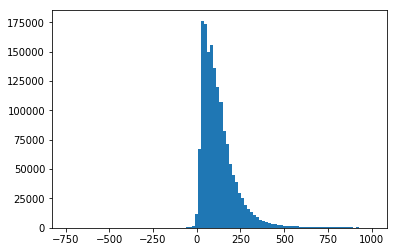

In [82]:
from matplotlib.pyplot import hist

# departure_delays[departure_delays['departure_delay'] < -1000] = 0
# departure_delays[departure_delays['departure_delay'] > 1000] = 0

hist(departure_delays.departure_delay, bins=100)

In [86]:
departure_delays.departure_delay.corr(arrival_delays.arrival_delay)

0.7774452238049401